## <b><font color='darkblue'>Preface</font></b>
([source](https://realpython.com/langgraph-python/?fbclid=IwZXh0bgNhZW0CMTEAAR6wBnQpFfskJnubHhtPKpXLUjnoDzFtpHy2cwGMmslw5lZyysdVxaC6UyuatA_aem_ytzTtBvnm47u4-OB0E_dkw)) <font size='3ptx'><b>[LangGraph](https://www.langchain.com/langgraph) is a versatile Python library designed for stateful, cyclic, and multi-actor [**Large Language Model**](https://en.wikipedia.org/wiki/Large_language_model) (LLM) applications</b>. LangGraph builds upon its parent library, [**LangChain**](https://www.langchain.com/), and allows you to build sophisticated workflows that are capable of handling the complexities of real-world LLM applications.</font>

By the end of this tutorial, you’ll understand that:
* You can use [**LangGraph**](https://www.langchain.com/langgraph) to build LLM workflows by defining state graphs with nodes and edges.
* [**LangGraph**](https://www.langchain.com/langgraph) expands [**LangChain**](https://www.langchain.com/)’s capabilities by providing tools to build complex LLM workflows with state, conditional edges, and cycles.
* LLM agents in [**LangGraph**](https://www.langchain.com/langgraph) autonomously process tasks using state graphs to make decisions and interact with tools or APIs.
* You can use [**LangGraph**](https://www.langchain.com/langgraph) independently of [**LangChain**](https://www.langchain.com/), although they’re often used together to complement each other.


Explore the full tutorial to gain hands-on experience with [**LangGraph**](https://www.langchain.com/langgraph), including setting up workflows and building a LangGraph agent that can autonomously parse emails, send emails, and interact with API services.


While you’ll get a brief primer on [**LangChain**](https://www.langchain.com/) in this tutorial, you’ll benefit from having prior knowledge of LangChain fundamentals. You’ll also want to ensure you have intermediate Python knowledge—specifically in object-oriented programming concepts like classes and methods.

### <b><font color='darkgreen'>Install LangGraph</font></b>
LangGraph is available on PyPI, and you can install it with pip. Open a terminal or command prompt, create a new virtual environment, and then run the following command:
```shell
(venv) $ python -m pip install langgraph
```

In [1]:
!pip freeze | grep langgraph

langgraph==0.3.25
langgraph-checkpoint==2.0.24
langgraph-prebuilt==0.1.8
langgraph-sdk==0.1.61


You’ll also need a few more libraries for this tutorial:
```shell
(venv) $ pip install langchain-openai "pydantic[email]"
```

In [2]:
!pip freeze | grep -P '(langchain-openai|pydantic)'

langchain-openai==0.3.12
pydantic==2.10.6
pydantic-settings==2.8.1
pydantic_core==2.27.2


You’ll use [`langchain-openai`](https://github.com/langchain-ai/langchain) to interact with OpenAI LLMs, but keep in mind that **you can use any LLM provider you like with LangGraph and LangChain**. You’ll **use [pydantic](https://realpython.com/python-pydantic/) to validate the information your agent parses from emails**.

Before moving forward, if you choose to use OpenAI, make sure you’re signed up for an OpenAI account and that you have a valid [**API key**](https://openai.com/api/). You’ll need to set the following [environment variable](https://en.wikipedia.org/wiki/Environment_variable) before running any examples in this tutorial:
```shell
OPENAI_API_KEY=<YOUR-OPENAI-API-KEY>
```

Note that while LangGraph was made by the creators of LangChain, and the two libraries are highly compatible, it’s possible to use LangGraph without LangChain. However, it’s more common to use LangChain and LangGraph together, and you’ll see throughout this tutorial how they complement each other.

In [2]:
import os
from dotenv import load_dotenv, find_dotenv

# We defined the environment variable `OPENAI_API_KEY` in `~/.env`
_ = load_dotenv(find_dotenv(os.path.expanduser('~/.env')))

<b>With that, you’ve installed all the dependencies you’ll need for this tutorial, and you’re ready to create your LangGraph email processor</b>. Before diving in, you’ll take a brief detour to set up quick sanity tests for your app. Then, <b>you’ll go through an overview of LangChain chains and explore LangGraph’s core concept—the state graph</b>.

### <b><font color='darkgreen'>Create Test Cases</font></b>
<font size='3ptx'><b>When developing AI applications, testing and performance tracking is crucial for understanding how your chain, graph, or agent performs in the real world.</b> While performance tracking is out of scope for this tutorial, you’ll use several example emails to test your chains, graphs, and agent, and you’ll empirically inspect whether their outputs are correct</font>.

To avoid redefining these examples each time, create the following Python file with example emails:

In [8]:
EMAILS = [
    # Email 0
    """
    Date: October 15, 2024
    From: Occupational Safety and Health Administration (OSHA)
    To: Blue Ridge Construction, project 111232345 - Downtown Office
    Complex Location: Dallas, TX

    During a recent inspection of your construction site at 123 Main
    Street,
    the following safety violations were identified:

    Lack of fall protection: Workers on scaffolding above 10 feet
    were without required harnesses or other fall protection
    equipment. Unsafe scaffolding setup: Several scaffolding
    structures were noted as
    lacking secure base plates and bracing, creating potential
    collapse risks.
    Inadequate personal protective equipment (PPE): Multiple
    workers were
    found without proper PPE, including hard hats and safety
    glasses.
    Required Corrective Actions:

    Install guardrails and fall arrest systems on all scaffolding
    over 10 feet. Conduct an inspection of all scaffolding
    structures and reinforce unstable sections. Ensure all
    workers on-site are provided
    with necessary PPE and conduct safety training on proper
    usage.
    Deadline for Compliance: All violations must be rectified
    by November 10, 2024. Failure to comply may result in fines
    of up to
    $25,000 per violation.

    Contact: For questions or to confirm compliance, please reach
    out to the
    OSHA regional office at (555) 123-4567 or email
    compliance.osha@osha.gov.
    """,
    # Email 1
    """
    From: debby@stack.com
    Hey Betsy,
    Here's your invoice for $1000 for the cookies you ordered.
    """,
    # Email 2
    """
    From: tdavid@companyxyz.com
    Hi Paul,
    We have an issue with the HVAC system your team installed in
    apartment 1235. We'd like to request maintenance or a refund.
    Thanks,
    Terrance
    """,
    # Email 3
    """
    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring to meet electrical safety
    standards. Install additional fire extinguishers in compliance with
    fire code requirements. Reinforce or replace temporary support beams
    to ensure structural stability. Deadline for Compliance: Violations
    must be addressed no later than February 5,
    2025. Failure to comply may result in
    a stop-work order and additional fines.
    Contact: For questions or to schedule a re-inspection, please contact
    the Building and Safety Department at
    (555) 456-7890 or email inspections@lacity.gov.
    """,
]

You can read through these right now if you want, but you’ll get links back to these test emails throughout the tutorial.

### <b><font color='darkgreen'>Preview of State Graphs</font></b>
<font size='3ptx'><b>As you might have inferred from the name, LangGraph is all about implementing LLM applications as directed graphs.</b> You can think of a directed graph as a sequence of instructions composed of nodes and edges, that tell you how to complete a task.</font>

In [**LangGraph**](https://www.langchain.com/langgraph), <b>nodes represent actions that your graph can take, such as calling a function, and edges tell you which node to go to next</b>.

To understand this better, take a look at this directed graph:
![graph](https://realpython.com/cdn-cgi/image/width=1418,format=auto/https://files.realpython.com/media/Screenshot_2024-11-25_at_2.28.24_PM.ab4b12f7d677.png)

This graph models what you might do when you eat a meal in a cafeteria. It consists of two actions represented by nodes: <b>Buy Food</b> and <b>Eat Food</b>. Once you’ve eaten, you ask yourself: `Am I still hungry`, or `am I full`?

The dotted arrows, which are edges, represent the answers to this question. If you’re still hungry, you buy more food and eat it. This cycle continues until you’re full, at which point you leave the cafeteria.

This simple example illustrates the essence of how LangGraph represents and implements LLM applications. In this tutorial, you’re going to step into the shoes of an AI engineer at a large real estate development firm and build a graph to process emails from regulatory agencies. Your graph will:
* Extract structured fields like dates, names, phone numbers, and locations from email messages
* Notify internal stakeholders if an email requires immediate escalation
* Create tickets with your company’s legal team using the information extracted from the email
* Forward and reply to emails that were sent to the wrong address

To understand why [**LangGraph**](https://www.langchain.com/langgraph) is a great choice for building this type of application, you’ll begin by reviewing and building a [**LangChain**](https://www.langchain.com/) chain, and you’ll see why chains can’t accomplish the tasks listed above.

### <b><font color='darkgreen'>LangChain Chains and Their Limitations</font></b>
<font size='3ptx'><b>Suppose you work for a large real estate development company. Your company receives hundreds of emails a day from regulatory entities and other organizations regarding active construction sites.</b> For instance, your company might receive a notice from an inspector saying that a construction site doesn’t comply with safety regulations.</font>

<b>Your job is to build a tool that can read these emails, extract critical information from them, and notify the correct internal team who will take action</b>. 

<b>The first step you’ll take to accomplish this is to build a LangChain chain that uses an LLM to extract structured fields from a regulatory notice email</b>. You start by defining a Pydantic [**BaseModel**](https://docs.pydantic.dev/latest/api/base_model/) that describes all the fields you want to extract from the email:

In [5]:
from datetime import datetime, date
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field, computed_field


class NoticeEmailExtract(BaseModel):
    date_of_notice_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date of the notice (if any) reformatted
        to match YYYY-mm-dd""",
    )
    entity_name: str | None = Field(
        default=None,
        description="""The name of the entity sending the notice (if present
        in the message)""",
    )
    entity_phone: str | None = Field(
        default=None,
        description="""The phone number of the entity sending the notice
        (if present in the message)""",
    )
    entity_email: str | None = Field(
        default=None,
        description="""The email of the entity sending the notice
        (if present in the message)""",
    )
    project_id: int | None = Field(
        default=None,
        description="""The project ID (if present in the message) -
        must be an integer""",
    )
    site_location: str | None = Field(
        default=None,
        description="""The site location of the project (if present
        in the message). Use the full address if possible.""",
    )
    violation_type: str | None = Field(
        default=None,
        description="""The type of violation (if present in the
        message)""",
    )
    required_changes: str | None = Field(
        default=None,
        description="""The required changes specified by the entity
        (if present in the message)""",
    )
    compliance_deadline_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date that the company must comply (if any)
        reformatted to match YYYY-mm-dd""",
    )
    max_potential_fine: float | None = Field(
        default=None,
        description="""The maximum potential fine
        (if any)""",
    )

    @staticmethod
    def _convert_string_to_date(date_str: str | None) -> date | None:
        try:
            return datetime.strptime(date_str, "%Y-%m-%d").date()
        except Exception as e:
            print(e)
            return None

    @computed_field
    @property
    def date_of_notice(self) -> date | None:
        return self._convert_string_to_date(self.date_of_notice_str)

    @computed_field
    @property
    def compliance_deadline(self) -> date | None:
        return self._convert_string_to_date(self.compliance_deadline_str)

You first import all of the dependencies you’ll need to create your chain. Then, you define <b><font color='blue'>NoticeEmailExtract</font></b><b>, which is a Pydantic BaseModel that provides type definitions and descriptions of each field you want to extract</b>. Downstream, LangChain will pass the information in the <b><font color='blue'>NoticeEmailExtract</font></b> definition to an LLM as raw text. <b>The LLM will try to extract these fields from an email based on the type hints and description parameters in <font color='blue'>Field(...)</font></b>.

As an example, the LLM will try to identify and extract the `project ID` corresponding to the construction site discussed in the email. If successfully extracted, the LLM will return the project ID in a [**JSON**](https://realpython.com/python-json/) object with an integer `project_id` entry. If it’s unable to extract a project ID, the `project_id` entry will be None.

You may have noticed that `date_of_notice` and `compliance_deadline` are Pydantic [**computed field**](https://docs.pydantic.dev/2.0/usage/computed_fields/) properties that are derived from `date_of_notice_str` and `compliance_deadline_str`, respectively. **Since OpenAI LLMs can’t natively extract fields as a date data type, the LLM first extracts dates as strings. Then, you use computed field properties to convert those strings to dates**.

For example, the LLM extracts `2025-01-01` for `date_of_notice_str`. Your <b><font color='blue'>NoticeEmailExtract</font></b> instance will convert this to a date object for `January 1, 2025`, and it will store this in a new field called `date_of_notice`.

Also, because `exclude` is `True` and `repr` is `False` in the definition of `date_of_notice_str`, you won’t see `date_of_notice_str` when you serialize or display <b><font color='blue'>NoticeEmailExtract</font></b>. It will be as if the LLM extracted `date_of_notice` directly as a date. (For more details of explanation here, refer to [API doc of Field here](https://docs.pydantic.dev/dev/api/fields/#pydantic.fields.Field))

Next, you create a chain to parse notice emails using <b><font color='blue'>NoticeEmailExtract</font></b>:

In [9]:
info_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

notice_parser_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

NOTICE_PARSER_CHAIN = (
    info_parse_prompt
    | notice_parser_model.with_structured_output(NoticeEmailExtract)
)

You define `info_parse_prompt` to tell the LLM how it should behave and which tasks it should accomplish. In this case, you’re instructing it to extract structured fields from an email notice. The `{message}` parameter is a placeholder that will store the email you pass through the chain.

You then instantiate a `ChatOpenAI` model using `gpt-4o-mini` as the foundation model—you can experiment with different LLM providers and models here. Lastly, you instantiate `NOTICE_PARSER_CHAIN` using the [**LangChain Expression Language (LCEL)**](https://realpython.com/build-llm-rag-chatbot-with-langchain/#chains-and-langchain-expression-language-lcel).

This statement creates a chain that injects an email into the `message` parameter of `info_parse_prompt`. It then passes the output of `info_parse_prompt` to `notice_parser_model`. By calling `.with_structured_output(NoticeEmailExtract)`, [**LangChain**](https://www.langchain.com/) converts your <b><font color='blue'>NoticeEmailExtract</font></b> base model to a prompt that tells the LLM to adhere its output to the schema defined by <b><font color='blue'>NoticeEmailExtract</font></b>.

To bring this all together, let's test `NOTICE_PARSER_CHAIN` on an example email notice:

In [18]:
output = NOTICE_PARSER_CHAIN.invoke({"message": EMAILS[0]})

In order to leverage package `devtools` to print Pydantic BaseModel in a nice way, you have to install it:
```shell
$ pip install devtools
```

In [23]:
!pip freeze | grep 'devtools'

devtools==0.12.2


In [19]:
from devtools import pprint

pprint(output)

NoticeEmailExtract(
    entity_name='Occupational Safety and Health Administration (OSHA)',
    entity_phone='(555) 123-4567',
    entity_email='compliance.osha@osha.gov',
    project_id=111232345,
    site_location='123 Main Street, Dallas, TX',
    violation_type='Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)',
    required_changes=(
        'Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaf'
        'folding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PP'
        'E and conduct safety training on proper usage.'
    ),
    max_potential_fine=25000.0,
    date_of_notice=datetime.date(2024, 10, 15),
    compliance_deadline=datetime.date(2024, 11, 10),
)


You can see that `NOTICE_PARSER_CHAIN` successfully parses the email and returns a <b><font color='blue'>NoticeEmailExtract</font></b>. It’s pretty awesome that `NOTICE_PARSER_CHAIN`, and specifically `gpt-4o-mini`, pulled these fields out of raw text. <b>Think about how difficult it would be to write logic to do this without an LLM!</b>

You’ll see that `date_of_notice` and `compliance_deadline` are [**date**](https://docs.python.org/3/library/datetime.html#date-objects) objects, and `date_of_notice_str` and `compliance_deadline_str` aren’t displayed. This shows that the LLM successfully extracted the two dates as strings and your computed field properties converted them to [**date**](https://docs.python.org/3/library/datetime.html#date-objects) objects.

Not only did `NOTICE_PARSER_CHAIN` extract these fields, it did so with high accuracy. For example, `NOTICE_PARSER_CHAIN` extracted the date the notice was received, the entity that sent it, and even the maximum potential fine for non-compliance. Notice how all of the extracted fields are the correct data type that you specified when defining <b><font color='blue'>NoticeEmailExtract</font></b>—all of this without having to write a single line of type conversion logic

Next, you’ll <b>build another chain that you’ll use throughout this tutorial. This chain will check whether the email notice requires escalation within the company based on a text description of what constitutes escalation</b>.

For example, you might want to escalate a message if employees are in danger, or if the notice warns about a fine above a specified threshold. Here’s what the escalation chain looks like:

In [24]:
class EscalationCheck(BaseModel):
    needs_escalation: bool = Field(
        description="""Whether the notice requires escalation
        according to specified criteria"""
    )


escalation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Determine whether the following notice received
            from a regulatory body requires immediate escalation.
            Immediate escalation is required when {escalation_criteria}.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

escalation_check_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

ESCALATION_CHECK_CHAIN = (
    escalation_prompt
    | escalation_check_model.with_structured_output(EscalationCheck)
)

Here’s what `ESCALATION_CHECK_CHAIN` looks like in action:

In [27]:
escalation_criteria = 'There is currently water damage or potential water damage reported.'
message = 'Several cracks in the foundation have been identified along with water leaks'

output = ESCALATION_CHECK_CHAIN.invoke(
    {"message": message, "escalation_criteria": escalation_criteria})

In [28]:
pprint(output)

EscalationCheck(
    needs_escalation=True,
)


In [31]:
message = 'The wheel chair ramps are too steep'
output = ESCALATION_CHECK_CHAIN.invoke(
    {"message": message, "escalation_criteria": escalation_criteria})

In [32]:
pprint(output)

EscalationCheck(
    needs_escalation=False,
)


<b>You now have the first two components of your email parsing system built, but in isolation, `NOTICE_PARSER_CHAIN` and `ESCALATION_CHECK_CHAIN` don’t exactly solve your problems</b>. You want your system to take different actions depending on whether the email requires escalation. You also might want to check if the email even comes from a regulatory body, and forward it to the correct department if it doesn’t.

<b>This is where chains reach their limit. They’re not designed to handle state or make conditional decisions, such as determining which action to take if an email requires escalation</b>. To tackle more complex tasks, you’ll need more than a stateless chain that passes data linearly from one step to the next. <b>This is where [LangGraph](https://www.langchain.com/langgraph)’s core object—the state graph—comes in to help</b>.

## <b><font color='darkblue'>Work With State Graphs</font></b>

### <b><font color='darkgreen'>Build Your First State Graph</font></b>
<font size='3ptx'><b>Now that you’ve built the notice parsing and escalation check chains, you need to orchestrate them and add additional functionality that your company requires to process notice emails.</b> To do this, you’ll use LangGraph’s StateGraph to create a graph that builds upon `NOTICE_PARSER_CHAIN` and `ESCALATION_CHECK_CHAIN`.</font>

Before getting started, you’ll want to initialize a logger that you’ll use throughout this tutorial:

In [33]:
import logging

logging.getLogger("httpx").setLevel(logging.WARNING)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
LOGGER = logging.getLogger('demo')

Here, you initialize a standard logger that displays informational messages from all libraries besides `httpx`. For `httpx`, you’ll only show warnings. This will keep your logs clean later on in the tutorial.

<b><font color='orange'>Notes:</font></b> You’re not directly using `httpx` in your code. However, the `httpx` library is a dependency of LangGraph and is used under the hood to communicate with the AI models.

Now you can initialize your first graph:

In [3]:
from typing import TypedDict
from chains.escalation_check import ESCALATION_CHECK_CHAIN
from chains.notice_extraction import NOTICE_PARSER_CHAIN, NoticeEmailExtract
from langgraph.graph import END, START, StateGraph
from pydantic import EmailStr


class GraphState(TypedDict):
    notice_message: str
    notice_email_extract: NoticeEmailExtract | None
    escalation_text_criteria: str
    escalation_dollar_criteria: float
    requires_escalation: bool
    escalation_emails: list[EmailStr] | None
    follow_ups: dict[str, bool] | None
    current_follow_up: str | None

workflow = StateGraph(GraphState)

You first import dependencies. Notice that you import the chains you built previously. You then define <b><font color='blue'>GraphState</font></b>—a [**typed dictionary**](https://typing.readthedocs.io/en/latest/spec/typeddict.html#typeddict) that defines the information each node in your graph updates and passes to the next node. Note that by inheriting from [**TypedDict**](https://docs.python.org/3/library/typing.html#typing.TypedDict), [**LangGraph**](https://www.langchain.com/langgraph) ensures each field in <b><font color='blue'>GraphState</font></b> has the correct type when populated. Here’s what each field in <b><font color='blue'>GraphState</font></b> stores:
* **`notice_message`**: The notice email that you want to parse and process.
* **`notice_email_extract`**: A <b><font color='blue'>NoticeEmailExtract</font></b> instance, which is the output of running `notice_message` through `NOTICE_PARSER_CHAIN`. When you initialize the graph, `notice_email_extract` is None.
* **`escalation_text_critera`**: A text description of how to determine whether an email notice requires immediate escalation.
* **`escalation_dollar_criteria`**: A threshold for the smallest maximum potential fine used to determine whether escalation is needed.
* **`requires_escalation`**: A Boolean indicating whether the notice requires escalation.
* **`escalation_emails`**: A list of email addresses to notify if escalation is required.
* **`follow_ups`**: A dictionary that stores follow-up questions that your graph needs to answer about the notice message before creating a legal ticket. You’ll learn more about this in the next section.
* **`current_follow_up`**: The current follow-up question your graph needs to answer.

You then initialize a <b><font color='blue'>GraphState</font></b> instance, passing <b><font color='blue'>GraphState</font></b> as an argument, and assign it to the variable `workflow`. At this point, `workflow` is an empty graph that can’t do anything. <b>To make `workflow` functional, you need to add nodes and edges. In [LangGraph](https://www.langchain.com/langgraph), a node represents an action that your graph can take, and every action is defined by a function</b>.

For example, you can use `NOTICE_PARSER_CHAIN` and `ESCALATION_CHECK_CHAIN` as the first nodes in your graph:
- **`graphs/notice_extraction.py`**:

```python
# ...

def parse_notice_message_node(state: GraphState) -> GraphState:
    """Use the notice parser chain to extract fields from the notice"""
    LOGGER.info("Parsing notice...")
    notice_email_extract = NOTICE_PARSER_CHAIN.invoke(
        {"message": state["notice_message"]}
    )
    state["notice_email_extract"] = notice_email_extract
    return state

def check_escalation_status_node(state: GraphState) -> GraphState:
    """Determine whether a notice needs escalation"""
    LOGGER.info("Determining escalation status...")
    text_check = ESCALATION_CHECK_CHAIN.invoke(
        {
            "escalation_criteria": state["escalation_text_criteria"],
            "message": state["notice_message"],
        }
    ).needs_escalation

    if (
        text_check
        or state["notice_email_extract"].max_potential_fine
        >= state["escalation_dollar_criteria"]
    ):
        state["requires_escalation"] = True
    else:
        state["requires_escalation"] = False

    return state

workflow.add_node("parse_notice_message", parse_notice_message_node)
workflow.add_node("check_escalation_status", check_escalation_status_node)
```

Here, you define `parse_notice_message_node()`— a function that accepts your <b><font color='blue'>GraphState</font></b> instance, runs the `notice_message` attribute of `state` through <font color='blue'>NOTICE_PARSER_CHAIN.invoke()</font>, stores the results in the state, and returns the state. <b>In general, all node functions accept the graph state, perform some action, update the graph state, and return the graph state</b>.

Similarly, `check_escalation_status_node()` passes the `escalation_text_criteria` and `notice_message` from `state` through <font color='blue'>ESCALATION_CHECK_CHAIN.invoke()</font>. If the chain determines that escalation is required, or the extracted `max_potential_fine` is greater than `state["escalation_dollar_criteria"]`, the `requires_escalation` attribute is set to True.

<b>You then add the nodes to your graph with <font color='blue'>workflow.add_node()</font>, which is a method that accepts the name of your node and the function that determines what your node does</b>. For example, <font color='blue'>workflow.add_node("parse_notice_message", parse_notice_message_node)</font> assigns `parse_notice_message_node()` to a graph node `called parse_notice_message`. The graph passes state to `parse_notice_message_node()` and stores the output in an updated `state`.

<b>The next thing you need to do is add edges to your graph. Edges control the flow of data between nodes in your graph</b>. Said differently, after a node performs an action and updates your graph’s state, the edge flowing out of the node tells it which node to pass `state` to next. Here’s how you add edges to your graph:
- **`graphs/notice_extraction.py`**

```python
# ...

workflow.add_edge(START, "parse_notice_message")  # Line 3
workflow.add_edge("parse_notice_message", "check_escalation_status")  # Line 4
workflow.add_edge("check_escalation_status", END)  # Line 5

NOTICE_EXTRACTION_GRAPH = workflow.compile()
```

<b>You call <font color='blue'>workflow.add_edge()</font>, which accepts the names of the start and end nodes of the edge, respectively</b>. `START` is a predefined node representing the entry point of the graph, and `END` is the node that terminates the graph. Here’s what each edge definition does:
* On line 3, you add an edge from `START` to the `parse_notice_message node`.
* Then, line 4 adds an edge from `parse_notice_message` to `check_escalation_status`.
* Lastly, line 5 adds an edge to terminate the graph after running `check_escalation_status`.

You can now compile your graph by running <font color='blue'>workflow.compile()</font>, which creates a `Runnable` interface that can be invoked, streamed, batched, and run asynchronously just like chains.

To visualize your graph, open another Python REPL and run the following:

In [6]:
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH

image_data = NOTICE_EXTRACTION_GRAPH.get_graph().draw_mermaid_png()
with open('notice_extraction_graph.png', mode='wb') as f:
    f.write(image_data)

Here, you import `NOTICE_EXTRACTION_GRAPH` and use <font color='blue'>.get_graph().draw_mermaid_png()</font> to create an image of your graph. You then save the image to a file called `notice_extraction_graph.png`. Here’s what the image should look like:

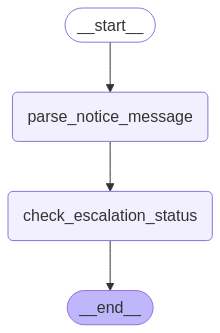

In [5]:
from IPython.display import Image
Image(filename='notice_extraction_graph.png')

This visual shows you that state flows from `parse_notice_message` to `check_escalation_status`, and it confirms that you’ve built your graph correctly. Here’s how you use your graph:

In [15]:
#from example_emails import EMAILS
from devtools import pprint
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH

initial_state = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": "There's a risk of fire or water damage at the site",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

In [12]:
final_state = NOTICE_EXTRACTION_GRAPH.invoke(initial_state)

2025-04-20 07:24:00,199 - INFO - Parsing notice...


ERROR! Session/line number was not unique in database. History logging moved to new session 6


2025-04-20 07:24:03,398 - INFO - Determining escalation status...


In [16]:
pprint(final_state["notice_email_extract"])

NoticeEmailExtract(
    entity_name='Occupational Safety and Health Administration (OSHA)',
    entity_phone='(555) 123-4567',
    entity_email='compliance.osha@osha.gov',
    project_id=111232345,
    site_location='123 Main Street, Dallas, TX',
    violation_type='Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)',
    required_changes=(
        'Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaf'
        'folding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PP'
        'E and conduct safety training on proper usage.'
    ),
    max_potential_fine=25000.0,
    date_of_notice=datetime.date(2024, 10, 15),
    compliance_deadline=datetime.date(2024, 11, 10),
)


In [17]:
final_state["requires_escalation"]

False

In this example, you import `NOTICE_EXTRACTION_GRAPH` and `EMAILS`. You then define your graph’s initial state with `EMAILS[0]` as the `notice_message`, escalation criteria, and a few other fields that you’ll use later in this tutorial. After calling <font color='blue'>NOTICE_EXTRACTION_GRAPH.invoke(initial_state)</font>, your `final_state` stores the extracted notice fields along with the `requires_escalation` flag.

Notice that in `final_state`, `notice_email_extract` is now a <font color='blue'><b>NoticeEmailExtract</b></font> object. Also, `requires_escalation` is set to `False` because `EMAILS[0]` doesn’t say anything about fire or water damage, and the maximum potential fine is less than $100,000.

With that, you’ve built and successfully run your first state graph! If you’re thinking that this graph isn’t any more useful than a chain at this point, you’re correct. <b>In the next section, you’ll address this by learning about and implementing [LangGraph](https://www.langchain.com/langgraph)’s differentiating feature — conditional edges</b>.

### <b><font color='darkgreen'>Work With Conditional Edges</font></b>
<font size='3ptx'><b>[LangGraph](https://www.langchain.com/langgraph) is all about modeling LLM workflows as graphs with nodes and edges</b>. Nodes represent actions that your graph can take like calling functions or invoking chains, and edges tell your graph how to navigate between nodes.</font>

## <b><font color='darkblue'>Supplement</font></b>
* [Medium - LangGraph for Beginners, Part 4: StateGraph.](https://medium.com/ai-agents/langgraph-for-beginners-part-4-stategraph-794004555369)